# Week 7
> ### Extract data from twitter on the 3 presidential candidates (use their names to search for them), Remove any data that isnt talking about the perform a sentiment analysis on them, let us see who has the most polarity (positive tweets). To do this, calculate the average for each individual.

## Import necessary libraries

In [2]:
import pandas as pd
import re
import twint
from textblob import TextBlob
from datetime import datetime
import nest_asyncio
import nltk
from nltk.corpus import stopwords

In [3]:
# Names of the presidential candidates for 2023 Election
candidate_name = {"Bola Ahmed Tinubu": "Bola Tinubu OR \ BAT",
                 "Peter Obi": "Obidient",
                 "Atiku Abubakar": "Atikulate"}

In [4]:
# Configure twint object
def twintConfig(search_string):
    c = twint.Config()
    c.Search = search_string[1]
    c.Limit = 1000
    c.Lang = "en"
    c.Pandas = True
    c.Pandas_au = True
    c.Pandas_clean =True
    c.Since = "2021-01-01"
    c.Until = "2022-12-31"
    c.Hide_output =True
    twint.run.Search(c)

In [6]:
# define function to run twint and save result to dataframe
def Run_Twint(search_vals):
    # set empty dataframe for join
    out_df = pd.DataFrame()
    
    for candidate in search_vals.items():
        print("running for search item:"+ candidate[0]+"\n")
        print("Search string: "+ candidate[1]+ "\n")
        
        # run twint
        twintConfig(candidate)
        
        #get DataFrame
        tweets_df = twint.storage.panda.Tweets_df
        
        # join Dataframes and create "candidate" column
        tweets_df["candidate"] = candidate[0]
        out_df = pd.concat([out_df, tweets_df])
        
    return out_df 

In [7]:
# Apply the nest_asyncio to avoid python looping error
nest_asyncio.apply()
tweets_df = Run_Twint(candidate_name)

running for search item:Bola Ahmed Tinubu

Search string: Bola Tinubu OR \ BAT

running for search item:Peter Obi

Search string: Obidient

running for search item:Atiku Abubakar

Search string: Atikulate

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


In [15]:
tweets_df.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,candidate
0,1608974613828218881,1608951354730631170,1.672444e+12,2022-12-31 00:53:35,+0100,,@jagabanolu Asiwaju Bola Ahmed Tinubu Please...,en,[],[],...,,,,,"[{'screen_name': 'jagabanolu', 'name': 'Jagaba...",,,,,Bola Ahmed Tinubu
1,1608970643781091328,1608970643781091328,1.672443e+12,2022-12-31 00:37:49,+0100,,We can all see that BAT did not make mistake w...,en,[],[],...,,,,,[],,,,,Bola Ahmed Tinubu
2,1608968998657589249,1608968998657589249,1.672443e+12,2022-12-31 00:31:17,+0100,,😂😁🙏 Our problem in Nigeria is letter B. Buhari...,tl,[],[],...,,,,,[],,,,,Bola Ahmed Tinubu
3,1608968540358586372,1608754481457659904,1.672443e+12,2022-12-31 00:29:27,+0100,,@timayatimaya With Asiwaju Bola Ahmed Tinubu a...,en,[],[],...,,,,,"[{'screen_name': 'timayatimaya', 'name': 'Tima...",,,,,Bola Ahmed Tinubu
4,1608968321797607424,1608968321797607424,1.672443e+12,2022-12-31 00:28:35,+0100,,Fulani from across the 36 states of the countr...,en,[tinubu],[],...,,,,,[],,,,,Bola Ahmed Tinubu


In [16]:
# dropping rows which language =! english ( removing all languages that are not English)
tweets_df["language"].unique()

array(['en', 'tl', 'in', 'vi', 'es', 'tr', 'hi', 'art', 'ca', 'und', 'ro',
       'ht', 'cy', 'nl', 'qam', 'et', 'fr', 'sv', 'sl', 'pt', 'zxx',
       'qme', 'it', 'ja', 'lt', 'qst', 'pl', 'ur', 'de', 'eu', 'cs'],
      dtype=object)

In [17]:
tweets_df = tweets_df[tweets_df["language"].isin(["en"])]

In [18]:
tweets_df["language"].unique()

array(['en'], dtype=object)

In [19]:
tweets_df.shape

(1719, 39)

In [20]:
# Removing all special charater in the tweets column using regular expression
def clean_text(text):
    """This function removes special charecters in the tweets"""
    pat1 = r'@[^ ]+'                   #@signs
    pat2 = r'https?://[A-Za-z0-9./]+'  #links
    pat3 = r'\'s'                      #floating s's
    pat4 = r'\#\w+'                     # hashtags
    pat5 = r'&amp '
    pat6 = r'[^A-Za-z\s]'         #remove non-alphabet
    combined_pat = r'|'.join((pat1, pat2,pat3,pat4,pat5, pat6))
    text = re.sub(combined_pat,"",text).lower()
    return text.strip()

In [21]:
tweets_df["tweet"] = tweets_df["tweet"].apply(clean_text)

C:\Users\TEMITOPE\AppData\Local\Temp\ipykernel_26268\2228119172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df["tweet"] = tweets_df["tweet"].apply(clean_text)


In [23]:
# Drop duplicated tweets, keep the first occurence
tweets_df = tweets_df.drop_duplicates(subset=["tweet", "candidate"], keep="first")

In [25]:
tweets_df.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,candidate
0,1608974613828218881,1608951354730631170,1.672444e+12,2022-12-31 00:53:35,+0100,,asiwaju bola ahmed tinubu please you are nee...,en,[],[],...,,,,,"[{'screen_name': 'jagabanolu', 'name': 'Jagaba...",,,,,Bola Ahmed Tinubu
1,1608970643781091328,1608970643781091328,1.672443e+12,2022-12-31 00:37:49,+0100,,we can all see that bat did not make mistake w...,en,[],[],...,,,,,[],,,,,Bola Ahmed Tinubu
3,1608968540358586372,1608754481457659904,1.672443e+12,2022-12-31 00:29:27,+0100,,with asiwaju bola ahmed tinubu as president co...,en,[],[],...,,,,,"[{'screen_name': 'timayatimaya', 'name': 'Tima...",,,,,Bola Ahmed Tinubu
4,1608968321797607424,1608968321797607424,1.672443e+12,2022-12-31 00:28:35,+0100,,fulani from across the states of the country ...,en,[tinubu],[],...,,,,,[],,,,,Bola Ahmed Tinubu
5,1608967017675259904,1608765456378363904,1.672443e+12,2022-12-31 00:23:24,+0100,,does bola tinubu really look like this this im...,en,[],[],...,,,,,"[{'screen_name': 'AderonkeW', 'name': 'Arabinr...",,,,,Bola Ahmed Tinubu


In [15]:
tweets_df.shape

(1605, 39)

In [28]:
# Download stopwords from the Natural Language toolkit
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TEMITOPE\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [30]:
# Removing stop words from DataFrame
stop = stopwords.words("english")
tweets_df["tweet_without_stopwords"] = tweets_df["tweet"].apply(lambda x: " ".join([word for word in x.split() if word not in (stop)]))

In [31]:
tweets_df.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,candidate,tweet_without_stopwords
0,1608974613828218881,1608951354730631170,1.672444e+12,2022-12-31 00:53:35,+0100,,asiwaju bola ahmed tinubu please you are nee...,en,[],[],...,,,,"[{'screen_name': 'jagabanolu', 'name': 'Jagaba...",,,,,Bola Ahmed Tinubu,asiwaju bola ahmed tinubu please needed come t...
1,1608970643781091328,1608970643781091328,1.672443e+12,2022-12-31 00:37:49,+0100,,we can all see that bat did not make mistake w...,en,[],[],...,,,,[],,,,,Bola Ahmed Tinubu,see bat make mistake said god bless pdapc g pd...
3,1608968540358586372,1608754481457659904,1.672443e+12,2022-12-31 00:29:27,+0100,,with asiwaju bola ahmed tinubu as president co...,en,[],[],...,,,,"[{'screen_name': 'timayatimaya', 'name': 'Tima...",,,,,Bola Ahmed Tinubu,asiwaju bola ahmed tinubu president commander ...
4,1608968321797607424,1608968321797607424,1.672443e+12,2022-12-31 00:28:35,+0100,,fulani from across the states of the country ...,en,[tinubu],[],...,,,,[],,,,,Bola Ahmed Tinubu,fulani across states country gathered lafia ca...
5,1608967017675259904,1608765456378363904,1.672443e+12,2022-12-31 00:23:24,+0100,,does bola tinubu really look like this this im...,en,[],[],...,,,,"[{'screen_name': 'AderonkeW', 'name': 'Arabinr...",,,,,Bola Ahmed Tinubu,bola tinubu really look like image extreme pho...


In [32]:
print("Running sentiment process")
# creating two new columns(polarity and subjectivity)
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

tweets_df["Subjectivity"] = tweets_df["tweet_without_stopwords"].apply(getSubjectivity)
tweets_df["Polarity"] = tweets_df["tweet_without_stopwords"].apply(getPolarity)

Running sentiment process


In [33]:
# A quick look at the subset of the DataFrame
tweets_df[["Subjectivity", "tweet_without_stopwords"]]

,Subjectivity,tweet_without_stopwords
0,0.000000,asiwaju bola ahmed tinubu please needed come t...
1,0.000000,see bat make mistake said god bless pdapc g pd...
3,0.000000,asiwaju bola ahmed tinubu president commander ...
4,0.500000,fulani across states country gathered lafia ca...
5,0.600000,bola tinubu really look like image extreme pho...
...,...,...
165,0.729167,atikulators atikulate winnin property damn goo...
167,0.000000,us atikulate
168,1.000000,wow show way self na atikulate
171,0.000000,time shall tell way atikulate


In [34]:
# Creating a column to show if the tweet is positive negative or neutral
def analysis(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"
tweets_df["Analysis"] = tweets_df["Polarity"].apply(analysis)

In [35]:
tweets_df

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,reply_to,retweet_date,translate,trans_src,trans_dest,candidate,tweet_without_stopwords,Subjectivity,Polarity,Analysis
0,1608974613828218881,1608951354730631170,1.672444e+12,2022-12-31 00:53:35,+0100,,asiwaju bola ahmed tinubu please you are nee...,en,[],[],...,"[{'screen_name': 'jagabanolu', 'name': 'Jagaba...",,,,,Bola Ahmed Tinubu,asiwaju bola ahmed tinubu please needed come t...,0.000000,0.000000,Neutral
1,1608970643781091328,1608970643781091328,1.672443e+12,2022-12-31 00:37:49,+0100,,we can all see that bat did not make mistake w...,en,[],[],...,[],,,,,Bola Ahmed Tinubu,see bat make mistake said god bless pdapc g pd...,0.000000,0.000000,Neutral
3,1608968540358586372,1608754481457659904,1.672443e+12,2022-12-31 00:29:27,+0100,,with asiwaju bola ahmed tinubu as president co...,en,[],[],...,"[{'screen_name': 'timayatimaya', 'name': 'Tima...",,,,,Bola Ahmed Tinubu,asiwaju bola ahmed tinubu president commander ...,0.000000,0.000000,Neutral
4,1608968321797607424,1608968321797607424,1.672443e+12,2022-12-31 00:28:35,+0100,,fulani from across the states of the country ...,en,[tinubu],[],...,[],,,,,Bola Ahmed Tinubu,fulani across states country gathered lafia ca...,0.500000,0.050000,Positive
5,1608967017675259904,1608765456378363904,1.672443e+12,2022-12-31 00:23:24,+0100,,does bola tinubu really look like this this im...,en,[],[],...,"[{'screen_name': 'AderonkeW', 'name': 'Arabinr...",,,,,Bola Ahmed Tinubu,bola tinubu really look like image extreme pho...,0.600000,0.037500,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,1606042392561229825,1606042392561229825,1.671745e+12,2022-12-22 22:41:59,+0100,,atikulators we atikulate any winnin on this pr...,en,[],[],...,[],,,,,Atiku Abubakar,atikulators atikulate winnin property damn goo...,0.729167,0.329167,Positive
167,1605929547572154371,1605927691126964224,1.671718e+12,2022-12-22 15:13:35,+0100,,all of us atikulate,en,[],[],...,"[{'screen_name': 'king_pearxe', 'name': 'Dr_St...",,,,,Atiku Abubakar,us atikulate,0.000000,0.000000,Neutral
168,1605928504981442561,1605927691126964224,1.671718e+12,2022-12-22 15:09:26,+0100,,wow show me the way now me self na atikulate,en,[],[],...,"[{'screen_name': 'king_pearxe', 'name': 'Dr_St...",,,,,Atiku Abubakar,wow show way self na atikulate,1.000000,0.100000,Positive
171,1605860910538452993,1605659516212764702,1.671702e+12,2022-12-22 10:40:51,+0100,,time shall tell all the way down atikulate,en,[],[],...,"[{'screen_name': 'Zayyan_ubandoma', 'name': 'Z...",,,,,Atiku Abubakar,time shall tell way atikulate,0.000000,0.000000,Neutral


In [144]:
# A quick look at the DataFrame without stopwords
tweets_df[["Polarity", "tweet_without_stopwords", "Analysis"]].head()

,Polarity,tweet_without_stopwords,Analysis
0,0.0000,asiwaju bola ahmed tinubu please needed come t...,Neutral
1,0.0000,see bat make mistake said god bless pdapc g pd...,Neutral
3,0.0000,asiwaju bola ahmed tinubu president commander ...,Neutral
4,0.0500,fulani across states country gathered lafia ca...,Positive
5,0.0375,bola tinubu really look like image extreme pho...,Positive


In [39]:
tweets_df.dtypes

id                                 object
conversation_id                    object
created_at                        float64
date                       datetime64[ns]
timezone                           object
place                              object
tweet                              object
language                           object
hashtags                           object
cashtags                           object
user_id                             int64
user_id_str                        object
username                           object
name                               object
day                                 int64
hour                               object
link                               object
urls                               object
photos                             object
video                               int64
thumbnail                          object
retweet                              bool
nlikes                              int64
nreplies                          

In [40]:
# Convert the date column to Pandas datetime format
tweets_df["date"] = pd.to_datetime(tweets_df["date"])

In [23]:
tweets_df.dtypes

id                         object
conversation_id            object
created_at                float64
date               datetime64[ns]
timezone                   object
place                      object
tweet                      object
language                   object
hashtags                   object
cashtags                   object
user_id                     int64
user_id_str                object
username                   object
name                       object
day                         int64
hour                       object
link                       object
urls                       object
photos                     object
video                       int64
thumbnail                  object
retweet                      bool
nlikes                      int64
nreplies                    int64
nretweets                   int64
quote_url                  object
search                     object
near                       object
geo                        object
source        

## Question 1: let us see who has the most polarity (positive tweets). To do this, calculate the average for each individual.

> The bar chart below shows that Peter Obi has the most positive tweets among the candidate

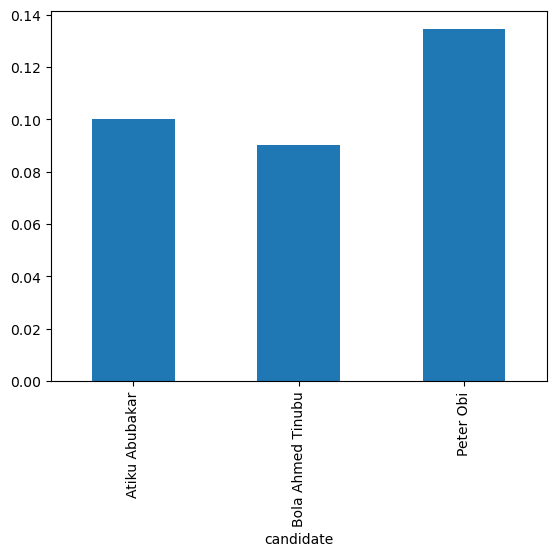

In [141]:
tweets_df.groupby("candidate")["Polarity"].mean().plot(kind="bar");

## Question 2: lets us see the candidate with the most subjective tweets (Emotional tweets). To do this, calculate the average for each individual.

> The bar chart below also shows that Peter Obi suppporter have the most sentiment in their tweets

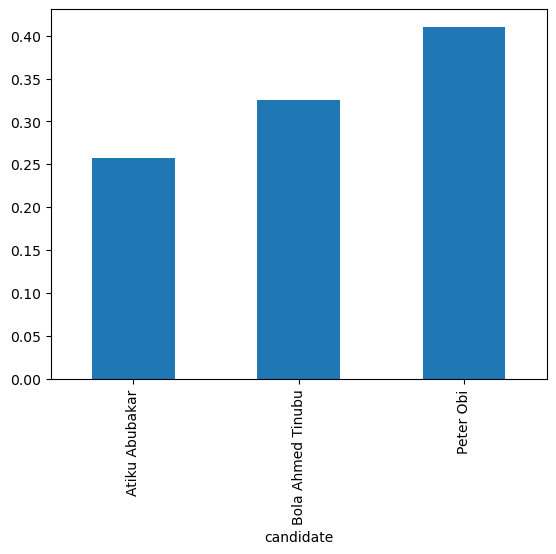

In [142]:
tweets_df.groupby("candidate")["Subjectivity"].mean().plot(kind="bar");

In [54]:
# Saving clean data to csv
df = pd.read_csv("candidates_tweets.csv")

In [110]:
df.groupby("candidate").nunique()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tweet_without_stopwords,Subjectivity,Polarity,Analysis
candidate,,,,,,,,,,,,,,,,,,,,,
Atiku Abubakar,131,119,131,131,1,0,131,1,5,1,...,0,88,0,0,0,0,131,40,40,3
Bola Ahmed Tinubu,650,580,649,649,1,0,650,1,52,1,...,0,160,0,0,0,0,648,149,145,3
Peter Obi,850,718,834,834,1,0,850,1,43,1,...,0,460,0,0,0,0,831,191,201,3


In [128]:
# Number of positive tweets by candidates
df.query("candidate == 'Atiku Abubakar' & Analysis == 'Positive'")[["Polarity"]].count()

Polarity    41
dtype: int64

In [129]:
df.query("candidate == 'Bola Ahmed Tinubu' & Analysis == 'Positive'")[["Polarity"]].count()

Polarity    263
dtype: int64

In [130]:
df.query("candidate == 'Peter Obi' & Analysis == 'Positive'")[["Polarity"]].count()

Polarity    441
dtype: int64